<a href="https://colab.research.google.com/github/PankajShukla/Stock-Market-Trend-Prediction/blob/main/Trend_Classification_Stock_Market_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Enhance an existing trading strategy by developing a more robust machine learning algorithm

# Library installation

In [1]:
!pip install Keras

In [2]:
import pandas as pd
import os
import numpy as np
import seaborn as sns
import datetime
sns.set_style('whitegrid')

%matplotlib inline
import matplotlib. pyplot as plt
import matplotlib
from sklearn.preprocessing import MinMaxScaler
from keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib. dates as mandates
from sklearn.preprocessing import MinMaxScaler
from sklearn import linear_model
from keras.models import Sequential
import keras.backend as K
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.models import load_model
from keras import callbacks

from sklearn.metrics import classification_report


import warnings
warnings.filterwarnings('ignore')
pd.set_option("display.max_column", 500)

from google.colab import drive

# Setting up Drive for pulling data

In [3]:
drive.mount('/content/drive', force_remount=True)
DrivePath = input('Enter Drive Path Location where the file is stored.')

Mounted at /content/drive
Enter Drive Path Location where the file is stored./content/drive/MyDrive/Data Scientist/Interview/Interview offline problem solving/Aditya Birla Group/


In [4]:
# /content/drive/MyDrive/Data Scientist/Interview/Interview offline problem solving/Aditya Birla Group/

# Loading the Dataset

In [29]:
cwdir = os.getcwd()
filename = 'Input_data.csv'
filename = os.path.join(cwdir,DrivePath,filename)


# Data Exploration, Data Cleaning and Metrics Derivation

In [34]:
def preprocess_data( data_years = [2011,2024] ):


  """
  -------------------------------------------------------
  Loading the data
  -------------------------------------------------------
  """

  df = pd.read_csv(filename)
  df.head(3)



  """
  -------------------------------------------------------
  Deriving fields and creating additional metrics
  -------------------------------------------------------
  """

  df['timestamp'] = pd.to_datetime(df['Date-Time'], format='%d/%m/%y %H:%M')

  df['date'] = df['timestamp'].dt.date

  df['dayofweek'] = df['timestamp'].dt.weekday
  df['dayofmonth'] = df['timestamp'].dt.day
  df['year'] = df['timestamp'].dt.year
  df['quarter'] = df['timestamp'].dt.quarter
  df['month'] = df['timestamp'].dt.month
  df['weekofyear'] = df['timestamp'].dt.isocalendar().week
  df['hour'] = df['timestamp'].dt.hour
  df['minute'] = df['timestamp'].dt.minute

  df['prev_Close'] = df['Close'].shift(1)
  df['prev_Close'].fillna(df['Close'], inplace=True)

  df['TR1'] = df['High']-df['Low']
  df['TR2'] = df['High']-df['prev_Close']
  df['TR3'] = df['Low'] -df['prev_Close']

  df['TR'] = df[['TR1','TR2','TR3']].max(axis=1)

  df['ATR'] = df['Close'].rolling(14, min_periods=1).mean()
  df['SMA_50'] = df['Close'].rolling(50, min_periods=1).mean()
  df['EMA_50'] = df['Close'].ewm(com=2).mean()



  """
  -------------------------------------------------------
  EDA
  -------------------------------------------------------
  """

  df_reading_cnt = df.groupby('date')['timestamp'].nunique().reset_index()
  print(df_reading_cnt.describe())

  print(df.year.value_counts().reset_index().sort_values('year'))
  print(df_reading_cnt[df_reading_cnt.timestamp<68].date.unique())
  print(df.Trend_final.value_counts())
  df.drop(columns=['prev_Close', 'TR1', 'TR2', 'TR3'], inplace=True)
  print(df.Trend_final.value_counts())

  """
  -------------------------------------------------------
  Selecting data size for entire exercise
  -------------------------------------------------------
  """

  org_df = df.copy(deep=True)

  df = df[ (df.year>=data_years[0]) & (df.year<=data_years[1])]
  print(df.year.value_counts().reset_index().sort_values('year'))
  print(df.Trend_final.value_counts())

  return df,org_df



# Correlation Plot

In [38]:
def correlation_plot(_df):

  fig, axes = plt.subplots(1,1, figsize = (14,10))
  numerical_fields = ['Open', 'High', 'Low', 'Close', 'cci_50',
                      'Close_supertrend_diff', 'ATR_EMA_diff', 'Trend_initial', 'Trend_final',
                      'TR', 'ATR', 'SMA_50', 'EMA_50']
  sns.heatmap(_df[numerical_fields].corr(), cmap="RdBu", annot=True, ax=axes)
  plt.show()


1.   Open, Close, High, Low, ATR, SMA50, EMA50 are high correlated
2.   Trend initial and Trend Final are highly correlated
3.   Trend initial and Trend Final both have med to high negative correlated to CCI50
4.   Close, CCI50, TR, Close supertrend diff, ATR_EMA_diff can be used as features for the model
5.   Trend Final can be used as Target variable





# Scaling function

In [32]:
def variable_scaling( df, features, output_var):

  #Scaling
  scaler = MinMaxScaler()
  feature_transform = scaler.fit_transform(df[features])
  feature_transform = pd.DataFrame(columns=features, data=feature_transform, index=df.index)

  return feature_transform

# Time Series Data - Test Train Split Function

In [19]:
def Timeseries_Test_Train_split(feature_transform, output_var, val_split):


  #Splitting to Training set, Validation set and Test set
  X_train, X_val, X_test = np.split(feature_transform, [int(val_split[0]*len(feature_transform)), int(val_split[1]*len(feature_transform))])
  y_train, y_val, y_test = np.split(output_var, [int(val_split[0]*len(output_var)), int(val_split[1]*len(output_var))])
  y_train, y_val, y_test = y_train.values.ravel(), y_val.values.ravel(), y_test.values.ravel()

  return X_train, X_val, X_test, y_train, y_val, y_test



# LSTM model development

In [20]:
def LSTM_model_training(X_train, y_train, X_val, y_val, modelfilename, csvlogsfilename, _nepoch, _nbatchsize, _verbose):

  """
  ------------------------------------------------
  Building the LSTM Model
  ------------------------------------------------
  """


  lstm = Sequential()
  lstm.add(LSTM(8, input_shape=(1, X_train.shape[2]), activation='relu', return_sequences=False))
  lstm.add(Dense(1, activation='sigmoid'))

  lstm.compile(loss='binary_crossentropy', optimizer= Adam(lr=0.01), metrics=['accuracy'])
  print(lstm.summary())

  print("Filepath :", modelfilename)
  print("Filepath :", csvlogsfilename)

  callbacks_lstm = [callbacks.EarlyStopping(monitor='accuracy', patience=3, verbose=1),
                    callbacks.CSVLogger(filename=csvlogsfilename, append=True),
                    callbacks.ModelCheckpoint(filepath=modelfilename, monitor='val_loss', save_best_only=True, verbose=1)
                   ]

  history = lstm.fit(X_train, y_train, validation_data=(X_val, y_val),epochs= _nepoch, batch_size= _nbatchsize, verbose=_verbose, shuffle=False, callbacks=callbacks_lstm)

  return lstm

# Classification report generating function

In [21]:
def generate_classification_report(_model, X_test, y_test ):
  testPredict = _model.predict(X_test)
  yPred = testPredict.ravel()

  yPred_ = []
  for v in yPred:
    if v>=0.5:
      yPred_.append(1)
    else:
      yPred_.append(0)

  print(classification_report(yPred_, y_test))
  return yPred_

# Main Block to call all functions

In [42]:

def main(timestamp, _period = [2011,2024]):

  target_var ='Trend_final'

  modelfilename = 'model/stock_trend_lstm_'+timestamp+'.h5'
  modelfilename = os.path.join(cwdir,DrivePath,modelfilename)

  csvlogsfilename = 'model/logs_lstm_'+timestamp+'.csv'
  csvlogsfilename = os.path.join(cwdir,DrivePath,csvlogsfilename)

  df,org_df = preprocess_data(data_years = _period )

  correlation_plot(org_df)
  """
  ------------------------------------------------
  Target and Features
  ------------------------------------------------
  """
  output_var = pd.DataFrame(df['Trend_final'])
  features = ['Open', 'High', 'Low', 'Close', 'cci_50', 'Close_supertrend_diff', 'ATR_EMA_diff', 'Trend_initial']
  feature_transform = variable_scaling(df, features, output_var)


  """
  ------------------------------------------------
  Train, Test and Validation split
  ------------------------------------------------
  """

  val_split = [0.80, 0.90]
  X_train, X_val, X_test, y_train, y_val, y_test = Timeseries_Test_Train_split(feature_transform, output_var, val_split)

  print('Train Shape : {0}, Validation Shape : {1}, Test Shape : {2}'.format(X_train.shape, X_val.shape, X_test.shape))

  print('Train data Target variable distribution : ', df[df.index.isin(list(X_train.index))][target_var].value_counts())
  print('Validation data Target variable distribution : ', df[df.index.isin(list(X_val.index))][target_var].value_counts())
  print('Test data Target variable distribution : ', df[df.index.isin(list(X_test.index))][target_var].value_counts())


  """
  ------------------------------------------------
  Process the data for LSTM
  ------------------------------------------------
  """
  X_train = np.array(X_train).reshape(X_train.shape[0], 1, X_train.shape[1])
  X_val   = np.array(X_val).reshape(X_val.shape[0], 1, X_val.shape[1])
  X_test  = np.array(X_test).reshape(X_test.shape[0], 1, X_test.shape[1])

  LSTM_model = LSTM_model_training(X_train, y_train, X_val, y_val, modelfilename, csvlogsfilename, _nepoch=10, _nbatchsize=8, _verbose=1)


  """
  ------------------------------------------------
  Evaluation on Test data
  ------------------------------------------------
  """
  scores = LSTM_model.evaluate(X_test, y_test, verbose=1)
  print("Accuracy: %.2f%%" % (scores[1]*100))

  generate_classification_report(LSTM_model, X_test, y_test )

  return LSTM_model

# Run the script

         timestamp
count  3292.000000
mean     74.957169
std       1.039038
min      26.000000
25%      75.000000
50%      75.000000
75%      75.000000
max      75.000000
    year  count
9   2011  18366
8   2012  18368
1   2013  18600
12  2014  18146
5   2015  18440
6   2016  18375
2   2017  18525
7   2018  18375
11  2019  18150
0   2020  18723
4   2021  18454
3   2022  18523
10  2023  18364
13  2024   7350
[datetime.date(2015, 12, 21) datetime.date(2020, 3, 13)
 datetime.date(2021, 2, 24) datetime.date(2021, 12, 6)
 datetime.date(2023, 11, 6)]
Trend_final
0    174990
1     71769
Name: count, dtype: int64
Trend_final
0    174990
1     71769
Name: count, dtype: int64
   year  count
7  2011  18366
6  2012  18368
1  2013  18600
9  2014  18146
3  2015  18440
4  2016  18375
2  2017  18525
5  2018  18375
8  2019  18150
0  2020  18723
Trend_final
0    128852
1     55216
Name: count, dtype: int64


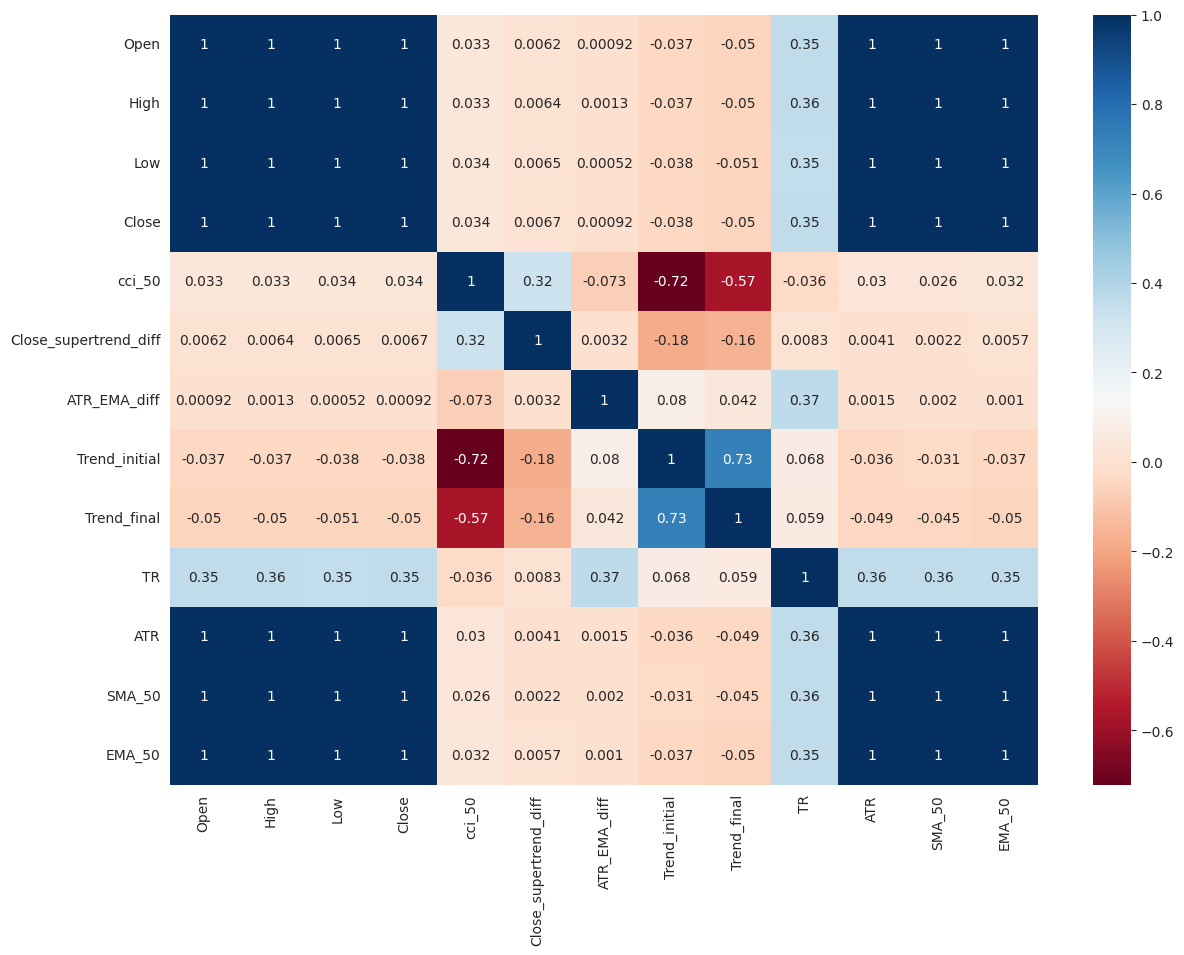

Train Shape : (147254, 8), Validation Shape : (18407, 8), Test Shape : (18407, 8)
Train data Target variable distribution :  Trend_final
0    102768
1     44486
Name: count, dtype: int64
Validation data Target variable distribution :  Trend_final
0    12589
1     5818
Name: count, dtype: int64
Test data Target variable distribution :  Trend_final
0    13495
1     4912
Name: count, dtype: int64
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 8)                 544       
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                                 
Total params: 553 (2.16 KB)
Trainable params: 553 (2.16 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Filepath : /conten

In [43]:

if __name__ == "__main__":
    # Execute the main function if the script is run directly
    timestamp = str(datetime.datetime.now())[:16].replace(' ','_H').replace(':','_M')
    LSTM_model = main(timestamp, _period = [2011,2020])

# Code Ends